In [83]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis import states
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import psutil
from matplotlib.ticker import FuncFormatter
import arcgis
from arcgis.gis import GIS
from arcgis.map import Map
from arcgis.features import GeoAccessor
import geopandas as gpd

In [3]:

%clear
#Function to check memory usage

def check_memory_usage():
    # Get virtual memory details
    virtual_memory = psutil.virtual_memory()

    # Print cache memory details
    print(f"Used Cache Memory: {virtual_memory.used / (1024 ** 2):.2f} MB")
    print(f"Available Cache Memory: {virtual_memory.available / (1024 ** 2):.2f} MB")

check_memory_usage()



Used Cache Memory: 30968.05 MB
Available Cache Memory: 34567.44 MB


In [4]:
#Variables to use to pull data from the Census API
#We're using the 2020 Decenial Census and the Demographic and Housing Characteristics dataset


YEAR = 2020
DATASET = 'dec/dhc' 

In [5]:

# Set the environment variable (for testing purposes)
load_dotenv()

# Retrieve the API key from the environment variable
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

totalpop = "P1_001N"
vacant = "H3_003N"
hhunit = "H1_001N"

targeted_state = states.PR
variables = ["NAME", "GEO_ID", totalpop, vacant, hhunit]

pr_block = ced.download(
    DATASET,
    YEAR,
    variables,
    state=targeted_state,
    block="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,  ##Optional if you want to use the TIGER shapefiles
    api_key = CENSUS_API_KEY,
)


pr_county = ced.download(
    DATASET,
    YEAR,
    variables,
    state=targeted_state,
    county="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,
    api_key = CENSUS_API_KEY,
)


#Check cache memory usage 
check_memory_usage()

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

Used Cache Memory: 31246.21 MB
Available Cache Memory: 34289.27 MB


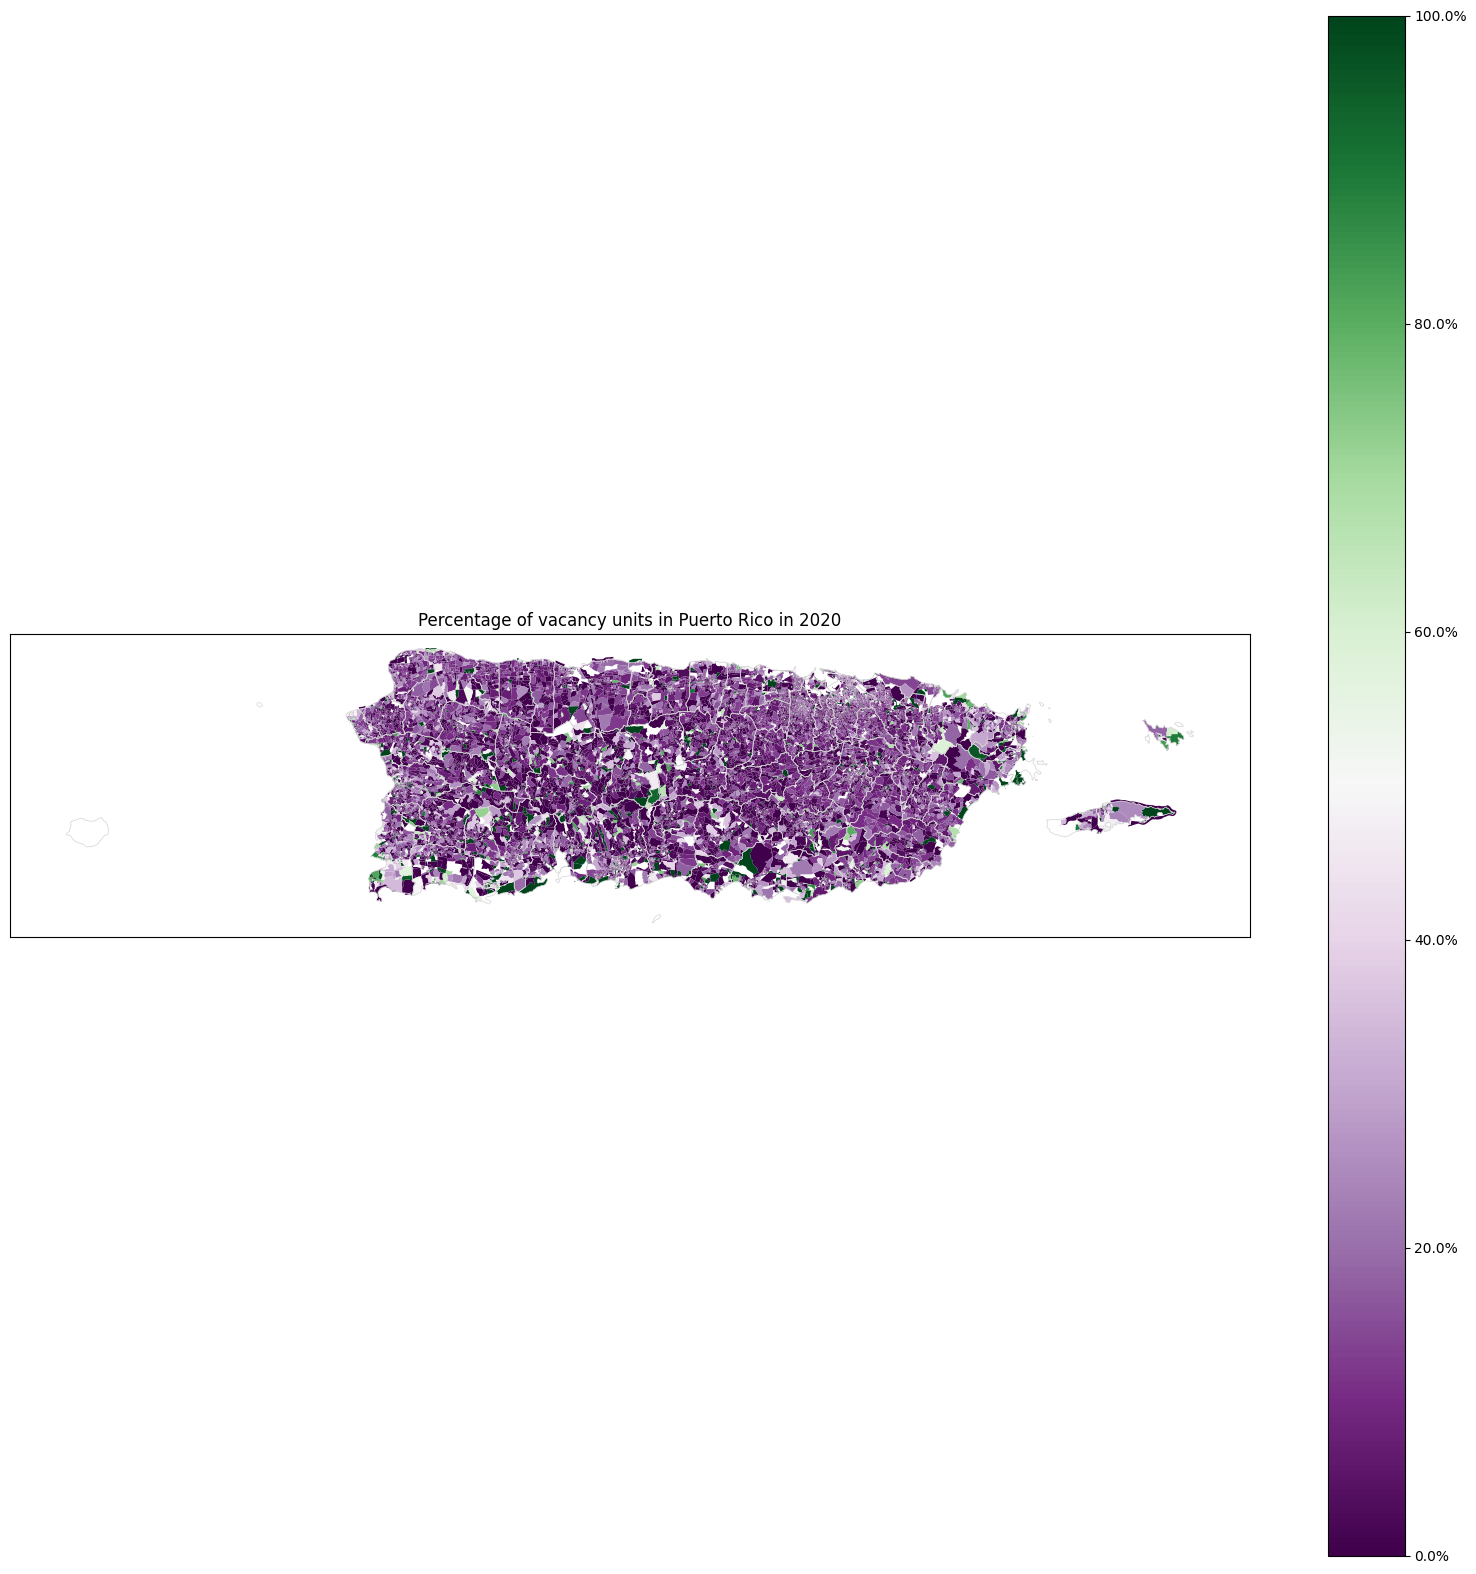

In [15]:
#With tiger shapefiles variable

# Plot the map with the given parameters
ax = cem.plot_map(pr_block, 
                    column=pr_block[vacant]/pr_block[hhunit]*100, 
                    # edgecolor="black", 
                    cmap="PRGn", 
                    legend=True, 
                    figsize=(20, 20),
                    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:,.1f}%")},
                    )
_ = ax.set_title("Percentage of vacancy units in Puerto Rico in 2020")

#Add county boundary to the map

ax = cem.plot_map(pr_county.boundary, color="lightgrey", linewidth=0.5, ax=ax)

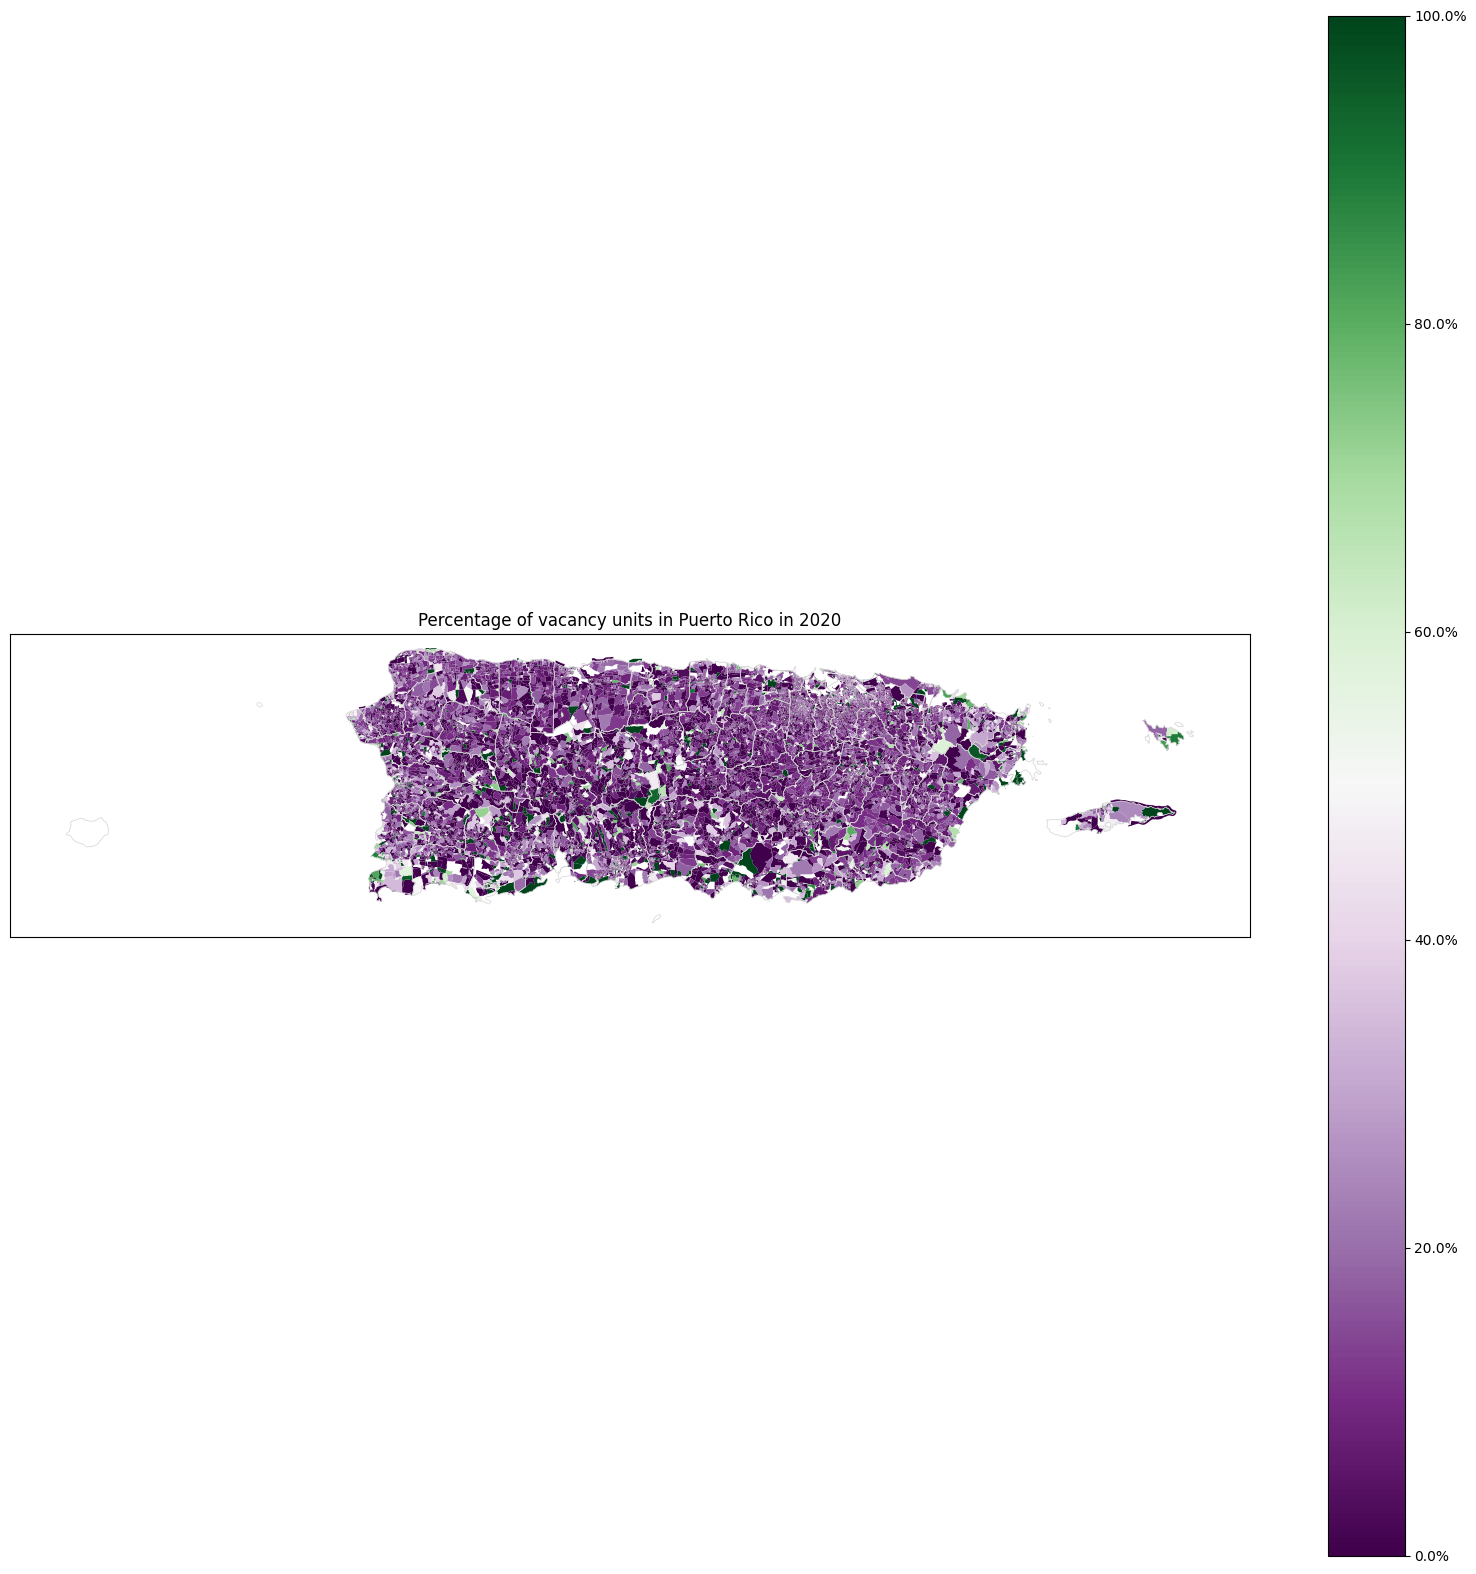

In [16]:
#Without tiger shapefiles variable

# Plot the map of vacancy percentage in Puerto Rico
ax = cem.plot_map(pr_block, 
                    column=pr_block[vacant]/pr_block[hhunit]*100, 
                    # edgecolor="black", 
                    cmap="PRGn", 
                    legend=True, 
                    figsize=(20, 20),
                    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:,.1f}%")},
                    )
_ = ax.set_title("Percentage of vacancy units in Puerto Rico in 2020")

#Add county boundary to the map
ax = cem.plot_map(pr_county.boundary, color="lightgrey", linewidth=0.5, ax=ax)


In [60]:
#Compare 2010 and 2020 vacancy data

pr_block_2010 = ced.download(
    "dec/sf1",
    2010,
    ["NAME", "GEO_ID", "P010001", "H003003", "H001001"],
    state=targeted_state,
    county="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,
    api_key = CENSUS_API_KEY,
    # remove_water = True,
)


pr_block_2020 = ced.download(
    DATASET,
    YEAR,
    variables,
    state=targeted_state,
    county="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,
    api_key = CENSUS_API_KEY,
    # remove_water = True,
)

check_memory_usage()

Used Cache Memory: 18921.78 MB
Available Cache Memory: 46613.71 MB


In [61]:
gdf_both_years = pr_block_2020.merge(pr_block_2010, on=["GEO_ID", "NAME"] , suffixes=("_2020", "_2010"))

In [62]:
vacant_variable_2020 = vacant
vacant_variable_2010 = "H003003"
total_change_percent = vacant + "_change_percent"
total_change = vacant + "_change"

In [63]:
gdf_both_years[total_change] = (
                                gdf_both_years[vacant_variable_2020]
                                  - gdf_both_years[vacant_variable_2010]
)

gdf_both_years[total_change_percent] = (
                                        100 
                                        * gdf_both_years[total_change]
                                        / gdf_both_years[vacant_variable_2010]
)
# Classify the data by quantile
gdf_both_years['quantile'] = pd.qcut(gdf_both_years[total_change], q=5, labels=False)

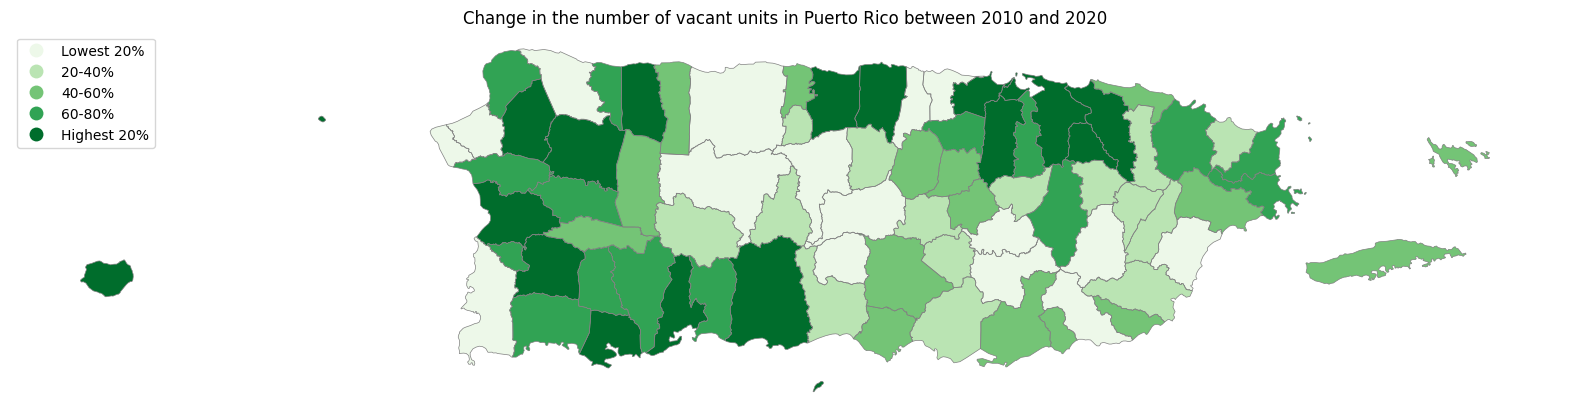

In [10]:


# Set the geometry for the GeoDataFrame
gdf_both_years.set_geometry("geometry_2020", inplace=True)

colors_list = ['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c']
quantile_labels = ['Lowest 20%', '20-40%', '40-60%', '60-80%', 'Highest 20%']

# Plot the GeoDataFrame
ax = cem.plot_map(gdf_both_years, 
             gdf_both_years["quantile"], 
             cmap=colors.ListedColormap(colors_list),
             figsize=(20, 20), 
             legend=True, 
             categorical=True,
             linewidth=0.25,
             legend_kwds={'labels' : quantile_labels, 
                        'loc': 'upper left'})

# Set the title
ax.set_title("Change in the number of vacant units in Puerto Rico between 2010 and 2020")


# Add county boundary to the map
cem.plot_map(pr_county.boundary, color="grey", linewidth=0.5, ax=ax)

ax.set_axis_off()


In [15]:
#Getting the imagery layer from the ArcGIS Online
load_dotenv()

TOKEN = os.getenv("TOKEN")

gis = GIS(api_key=TOKEN)
gis1 = GIS()
public_content = gis1.content.search("lecz", item_type="Imagery Layer", max_items=10)
lecz = public_content[0]
display(lecz)

<Item title:"Low Elevation Coastal Zones derived from MERIT-DEM" type:Imagery Layer owner:NASA_Earthdata>

In [104]:
map1 = Map("Puerto Rico")
map1.content.add(lecz)

In [110]:
gdf = gdf_both_years.set_geometry("geometry_2020")
sdf = GeoAccessor.from_geodataframe(gdf_both_years)
# sdf = sdf.spatial.set_geometry("SHAPE")
sdf.spatial.plot(map_widget=map1)

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

In [109]:
for index, row in sdf.iterrows():
    print(sdf["SHAPE"][index]["rings"])

[[[-66.837235, 18.192707], [-66.833579, 18.194256], [-66.832735, 18.195672], [-66.834795, 18.198514], [-66.834519, 18.201748], [-66.834093, 18.202797], [-66.834953, 18.20747], [-66.836366, 18.210145], [-66.834852, 18.21079], [-66.832848, 18.215189], [-66.834978, 18.218186], [-66.83295, 18.221165], [-66.830634, 18.221005], [-66.829792, 18.219989], [-66.829385, 18.223154], [-66.83058, 18.2251], [-66.832175, 18.226201], [-66.833263, 18.228021], [-66.832696, 18.229099], [-66.829142, 18.231802], [-66.825683, 18.232624], [-66.823104, 18.232325], [-66.820313, 18.231032], [-66.817598, 18.230437], [-66.817271, 18.230336], [-66.817058, 18.230121], [-66.815563, 18.230331], [-66.813167, 18.229279], [-66.811088, 18.228817], [-66.809741, 18.229475], [-66.808108, 18.228211], [-66.806867, 18.228414], [-66.803512, 18.227425], [-66.800469, 18.227842], [-66.798759, 18.230026], [-66.799972, 18.234023], [-66.800169, 18.235588], [-66.799531, 18.237171], [-66.800323, 18.237776], [-66.799223, 18.240176], [-66

In [ ]:
root_folder = gis.content.folders.get()

In [77]:
vacancy = gis.content.import_data(gdf_both_years)

In [72]:
import json

vacancy_fc_dict = dict(vacancy.properties)
vacancy_json = json.dumps({"featureCollection": {"layers" : [vacancy_fc_dict]}})


In [73]:
vacancy_json

'{"featureCollection": {"layers": [{"layerDefinition": {"currentVersion": 11.2, "id": 0, "name": "", "type": "Table", "displayField": "", "description": "", "copyrightText": "", "defaultVisibility": true, "relationships": [], "isDataVersioned": false, "supportsAppend": true, "supportsCalculate": true, "supportsASyncCalculate": true, "supportsTruncate": false, "supportsAttachmentsByUploadId": true, "supportsAttachmentsResizing": true, "supportsRollbackOnFailureParameter": true, "supportsStatistics": true, "supportsExceedsLimitStatistics": true, "supportsAdvancedQueries": true, "supportsValidateSql": true, "supportsCoordinatesQuantization": true, "supportsLayerOverrides": true, "supportsTilesAndBasicQueriesMode": true, "supportsFieldDescriptionProperty": true, "supportsQuantizationEditMode": true, "supportsApplyEditsWithGlobalIds": false, "advancedQueryCapabilities": {"supportsPagination": true, "supportsQueryAttachmentsCountOnly": true, "supportsPaginationOnAggregatedQueries": true, "su

In [42]:
vacancy_item_properties = {"title": "Vacancy in Puerto Rico 2010-2020",
                            "description": "This map shows the change in the number of vacant units in Puerto Rico between 2010 and 2020",
                            "tags": "arcgis python api, census, vacancy, puerto rico",
                            "text": vacancy_json,
                            "type": "Feature Collection"}


In [ ]:
vacancy_item = root_folder.add(vacancy_item_properties).result()
vacancy_item

In [78]:
vacancy_item

<Item title:"Vacancy in Puerto Rico 2010-2020" type:Feature Collection owner:hieutrn1205_columbia>

In [46]:
web_map_item = Map("Puerto Rico")
web_map_item.content.add(lecz)
web_map_item

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

In [26]:
gis.content.is_service_name_available(service_name="Puerto Rico Vacancy", service_type="featureService")

True

In [27]:
empty_service_item = gis.content.create_service(name="Puerto Rico Vacancy", service_type="featureService")

<Item title:"Puerto Rico Vacancy" type:Feature Layer Collection owner:hieutrn1205_columbia>

In [28]:
empty_service_item.layers


[]

In [30]:
from arcgis.features import FeatureLayerCollection

lecz_flc = FeatureLayerCollection.fromitem(empty_service_item)

In [31]:
lecz_flc.properties

{
  "currentVersion": 11.2,
  "serviceItemId": "cb67a55b358c496b8557e714cb3a1114",
  "serviceDescription": "",
  "hasVersionedData": false,
  "supportsDisconnectedEditing": false,
  "hasStaticData": false,
  "hasSharedDomains": false,
  "maxRecordCount": 1000,
  "supportedQueryFormats": "JSON",
  "supportsVCSProjection": false,
  "supportedExportFormats": "csv,shapefile,sqlite,geoPackage,filegdb,featureCollection,geojson,kml,excel",
  "supportedConvertFileFormats": "JSON,PBF",
  "supportedConvertContentFormats": "LayerEditCollection",
  "supportedFullTextLocales": [
    "neutral",
    "ar-SA",
    "bg-BG",
    "bn-IN",
    "ca-ES",
    "cs-CZ",
    "da-DK",
    "de-DE",
    "el-GR",
    "en-GB",
    "en-US",
    "es-ES",
    "fr-FR",
    "gu-IN",
    "he-IL",
    "hi-IN",
    "hr-HR",
    "id-ID",
    "is-IS",
    "it-IT",
    "ja-JP",
    "kn-IN",
    "ko-KR",
    "lt-LT",
    "lv-LV",
    "ml-IN",
    "mr-IN",
    "ms-MY",
    "nb-NO",
    "nl-NL",
    "pa-IN",
    "pl-PL",
    "pt-B

In [34]:
update_dcit = {"capabilities": "Query",
               "syncEnabled": False,}
lecz_flc.manager.update_definition(update_dcit)

{'success': True}